In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from os import listdir
import glob
import sncosmo
from ipywidgets import *
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
from sncosmo.salt2utils import BicubicInterpolator
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score
from warnings import filterwarnings
filterwarnings('ignore')

from tabulate import tabulate #to export in table format
%matplotlib inline

In [2]:
kernel = 0.5 * (RBF(length_scale=3, length_scale_bounds=(1, 30)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5,0.5)))

# Read the files

In [3]:
# file data paths
data_path = "./data/sp/"
file_names = glob.glob(data_path+"*.dat")
for i in range(0, len(file_names)):
    file_names[i] = file_names[i][10:]
print("Total files in path: ", len(file_names))

Total files in path:  2466


In [4]:
# auxiliar file 
sn_names = pd.read_csv("./data/list.dat",
                       header=None,
                       sep="\s+",
                       names=["name", "phase", "file_name"])
sn_names.head()

,name,phase,file_name
0,Test_SN0,-8.154,Test_SN0_0.dat
1,Test_SN0,-3.522,Test_SN0_1.dat
2,Test_SN0,17.959,Test_SN0_10.dat
3,Test_SN0,19.801,Test_SN0_11.dat
4,Test_SN0,19.816,Test_SN0_12.dat


In [5]:
names = sn_names["name"].unique()
print("Total number of sn files: ", len(names))

Total number of sn files:  171


# Training sample and simple graphs

In [6]:
w = widgets.Dropdown(
    options=names,
    value=names[0],
    description='SN name:',
    disabled=False,
)
display(w)

Dropdown(description='SN name:', options=('Test_SN0', 'Test_SN10', 'Test_SN11', 'Test_SN12', 'Test_SN13', 'Tes…

In [7]:
sn_spectra = glob.glob(data_path + w.value + "*.dat")

In [8]:
def spectra(i=0, plot=True):
    """
    function that returns the wavelenght, the flux and the flux error for a matplotlib graph or whatever spectra
    
    i = index of the element
    returns the wavelength, flux and flux error
    """
    if plot == True:
        data = sncosmo.read_lc(sn_spectra[i], format="salt2")
        return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]
    else:
        data = sncosmo.read_lc(data_path+file_names[i], format="salt2")
        return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]


## Spectra

In [9]:
# option list for jupyter lab widgets
optionslist = []
for i in range(0, len(sn_spectra)):
    optionslist.append(i)

def update_graph(i):
    """
    void function that updates a matplotlib graph
    """
    wave, flux, fluxe = spectra(i)
    plt.xlabel("$\lambda$  ($\AA$)")
    plt.ylabel("flux (erg/s/cm^2^/{AA} * random offset)")
    plt.plot(wave, flux, "k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Index: ', disabled=False)

widgets.interactive(update_graph,i=i) # to activate the interactive widget

interactive(children=(Dropdown(description='Index: ', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

## Monochromatic light curves

In [10]:
wave_number = 7000

time_lc = []
flux_lc = []

for i in range(0, len(sn_spectra)):
    wave, flux, fluxe = spectra(i)
    flux_lc.append(Spline1d(wave, flux,  k=1)(wave_number))
    time_lc.append(sn_names["phase"][sn_names["file_name"] == str(sn_spectra[i][10:])])

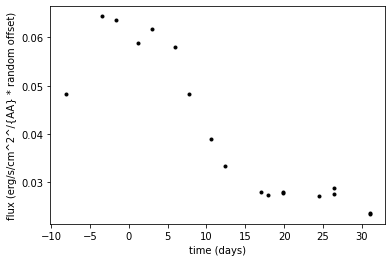

In [11]:
plt.plot(time_lc, flux_lc, "k.")
plt.xlabel("time (days)")
plt.ylabel("flux (erg/s/cm^2^/{AA} * random offset)");

## Training grid

In [12]:
"""
for i in range(0, len(file_names)):
    wave = spectra(i, plot=False)[0]
    phase = sn_names["phase"][sn_names["file_name"] == str(file_names[i])]
    plt.plot([phase,phase], [np.min(wave),np.max(wave)], 'k', linewidth=1)
    plt.xlabel("time (days)")
    plt.ylabel("$\lambda$ ($\AA$)")
    plt.xlim(-10, 50)
    plt.ylim(3500, 8500)
"""

'\nfor i in range(0, len(file_names)):\n    wave = spectra(i, plot=False)[0]\n    phase = sn_names["phase"][sn_names["file_name"] == str(file_names[i])]\n    plt.plot([phase,phase], [np.min(wave),np.max(wave)], \'k\', linewidth=1)\n    plt.xlabel("time (days)")\n    plt.ylabel("$\\lambda$ ($\\AA$)")\n    plt.xlim(-10, 50)\n    plt.ylim(3500, 8500)\n'

In [13]:
## Defining the grid
X_GRID = np.linspace(-10, 50, 61, dtype=int)
Y_GRID = np.linspace(3500, 8500, 501, dtype=int)

# Grid limits
print("time grid limits: ", np.min(X_GRID), ", ", np.max(X_GRID))
print("wavelenght grid limits: ", np.min(Y_GRID), ", ", np.max(Y_GRID))

time grid limits:  -10 ,  50
wavelenght grid limits:  3500 ,  8500


In [14]:
# split our data into a training and test dataset
np.random.seed(42)
sn_train, sn_test = train_test_split(names, test_size=0.2)
print(len(sn_train), len(sn_test))

136 35


In [15]:
def gaussian_process(wave, flux, error=True):
    """
    function that performs a gaussian process in a dataset of monochromatic light curves
    wave: Python list that gives the wavelenghts
    flux: np array that gives the flux
    error: binary variable to return or not the covariance in gaussian process regression
    
    return the corresponding gaussian process on data
    """
    # set the gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(wave, flux)
    if error==True:
        return gp.predict(X_GRID[:, np.newaxis], return_cov=True) # return mean and covariance
    else:
        return gp.predict(X_GRID[:, np.newaxis], return_cov=False) # return only mean     


In [16]:
def prepare_data_to_GP(wave):
    """
    function that convert a np array into a Python list for a gaussian process regression in SK-Learn
    wave: np array that gives the wavelenghts
    
    return the wavelenght in a correct format
    """
    temp_wave = [] # a new python list
    for ii in range(0, len(wave)):
        temp_wave.append([wave[ii]]) # correct SK-Learn format
    return temp_wave

In [17]:
def spectra_train(n_file):
    """
    function that returns the wavelenght, the flux and the flux error for a matplotlib graph or whatever spectra
    
    n_file: file name
    returns the wavelength, flux and flux error
    """
    data = sncosmo.read_lc(n_file, format="salt2")
    return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]

In [18]:
SPEC_TRAIN_FUN = []
SPEC_TRAIN_TIME = []
SPEC_TRAIN_MINMAX = []
for i in range(0, len(sn_train)):
    SPEC_TRAIN_FUN.append([]) # for spectra function
    SPEC_TRAIN_TIME.append([]) # for spectra time
    SPEC_TRAIN_MINMAX.append([]) # for min max spectra (in wavelenghts)

In [19]:
for i in range(0, len(sn_train)):
    sn_train_spectra = glob.glob(data_path + sn_train[i] + "_*.dat")
    for j in range(0, len(sn_train_spectra)):
        wave, flux, eflux = spectra_train(sn_train_spectra[j]) # to get wave, flux and flux error
        Nyquist_frequecy=1/15 #approx
        cutoff=1/100 #freq
        #print(cutoff/Nyquist_frequecy)
        b, a = signal.butter(8, cutoff/Nyquist_frequecy, analog=False)
        filtered_flux=signal.filtfilt(b, a, flux, padlen=0)
        SPEC_TRAIN_FUN[i].append(Spline1d(wave, filtered_flux)) # to register the corresponding function
        SPEC_TRAIN_TIME[i].append(float(sn_names["phase"][sn_names["file_name"] == str(sn_train_spectra[j][10:])])) # to regirster the corresponding spectra time
        SPEC_TRAIN_MINMAX[i].append([float(np.min(wave)), float(np.max(wave))]) # to register min and max wavelength that function is available

In [20]:
SPEC_GRID = []
for i in range(0, len(sn_train)):
    SPEC_GRID.append([]) # loop for each supernovae in trainingfrom scipy import signal

In [21]:
for i in range(0, len(SPEC_GRID)):
    for j in range(0, len(Y_GRID)):
        SPEC_GRID[i].append([[], []]) # for each supernovae and for each wavelengh we fill with time and flux lists
#SPEC_GRID[0][1][0]  # first sn, second wave list order, time or flux

In [22]:
for i in range(0, len(sn_train)): # sn train index
    print(i+1, "/", len(sn_train))
    for j in range(0, len(Y_GRID)): #  grid index
        for k in range(0, len(SPEC_TRAIN_FUN[i])): #func index
            if SPEC_TRAIN_MINMAX[i][k][0] < Y_GRID[j] < SPEC_TRAIN_MINMAX[i][k][1]: # if it's inside the bounds
                SPEC_GRID[i][j][0].append([SPEC_TRAIN_TIME[i][k]]) # time
                SPEC_GRID[i][j][1].append(np.float(SPEC_TRAIN_FUN[i][k](Y_GRID[j]))) # flux

1 / 136
2 / 136
3 / 136
4 / 136
5 / 136
6 / 136
7 / 136
8 / 136
9 / 136
10 / 136
11 / 136
12 / 136
13 / 136
14 / 136
15 / 136
16 / 136
17 / 136
18 / 136
19 / 136
20 / 136
21 / 136
22 / 136
23 / 136
24 / 136
25 / 136
26 / 136
27 / 136
28 / 136
29 / 136
30 / 136
31 / 136
32 / 136
33 / 136
34 / 136
35 / 136
36 / 136
37 / 136
38 / 136
39 / 136
40 / 136
41 / 136
42 / 136
43 / 136
44 / 136
45 / 136
46 / 136
47 / 136
48 / 136
49 / 136
50 / 136
51 / 136
52 / 136
53 / 136
54 / 136
55 / 136
56 / 136
57 / 136
58 / 136
59 / 136
60 / 136
61 / 136
62 / 136
63 / 136
64 / 136
65 / 136
66 / 136
67 / 136
68 / 136
69 / 136
70 / 136
71 / 136
72 / 136
73 / 136
74 / 136
75 / 136
76 / 136
77 / 136
78 / 136
79 / 136
80 / 136
81 / 136
82 / 136
83 / 136
84 / 136
85 / 136
86 / 136
87 / 136
88 / 136
89 / 136
90 / 136
91 / 136
92 / 136
93 / 136
94 / 136
95 / 136
96 / 136
97 / 136
98 / 136
99 / 136
100 / 136
101 / 136
102 / 136
103 / 136
104 / 136
105 / 136
106 / 136
107 / 136
108 / 136
109 / 136
110 / 136
111 / 13

In [23]:
"""
Nsn = 30
Nspec = 100
TIME_TEMP = SPEC_GRID[Nsn][Nspec][0]
FLUX_TEMP = SPEC_GRID[Nsn][Nspec][1]

gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(TIME_TEMP, FLUX_TEMP)
y_mean, y_cov = gp.predict(X_GRID[:, np.newaxis], return_cov=True) 

plt.plot(X_GRID, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_GRID, y_mean - np.sqrt(np.diag(y_cov)), y_mean + np.sqrt(np.diag(y_cov)), alpha=0.5, color='k')
plt.scatter(TIME_TEMP, FLUX_TEMP, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.xlabel("time (days)")
plt.ylabel("flux (a.u)")
"""

'\nNsn = 30\nNspec = 100\nTIME_TEMP = SPEC_GRID[Nsn][Nspec][0]\nFLUX_TEMP = SPEC_GRID[Nsn][Nspec][1]\n\ngp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(TIME_TEMP, FLUX_TEMP)\ny_mean, y_cov = gp.predict(X_GRID[:, np.newaxis], return_cov=True) \n\nplt.plot(X_GRID, y_mean, \'k\', lw=3, zorder=9)\nplt.fill_between(X_GRID, y_mean - np.sqrt(np.diag(y_cov)), y_mean + np.sqrt(np.diag(y_cov)), alpha=0.5, color=\'k\')\nplt.scatter(TIME_TEMP, FLUX_TEMP, c=\'r\', s=50, zorder=10, edgecolors=(0, 0, 0))\nplt.xlabel("time (days)")\nplt.ylabel("flux (a.u)")\n'

In [24]:
data_NSPEC_CUT = 7 # minimum number of spectra
data_NWAVE_CUT = 200 # wavelengh in a commom grid
SN_TRAIN = []
SN_TRAIN_ERROR = []
for i in range(0, len(sn_train)):
        SN_TRAIN.append([])
        SN_TRAIN_ERROR.append([])

In [25]:
for i in range(0, len(SPEC_GRID)):
    print(i+1, "/", len(SPEC_GRID))
    if len(SPEC_GRID[i][data_NWAVE_CUT][0]) > data_NSPEC_CUT:
        for j in range(0, len(Y_GRID)):
            TIME_TEMP = SPEC_GRID[i][j][0]
            FLUX_TEMP = SPEC_GRID[i][j][1]
            FLUX_TEMP, FLUX_ERROR_TEMP = gaussian_process(TIME_TEMP, FLUX_TEMP, error=True) # the brand new monochromatic light curves
            FLUX_ERROR_TEMP = np.sqrt(np.diag(FLUX_ERROR_TEMP))
            for k in range(0, len(FLUX_TEMP)):
                SN_TRAIN[i].append(FLUX_TEMP[k])
                SN_TRAIN_ERROR[i].append(FLUX_ERROR_TEMP[k])

1 / 136
2 / 136
3 / 136
4 / 136
5 / 136
6 / 136
7 / 136
8 / 136
9 / 136
10 / 136
11 / 136
12 / 136
13 / 136
14 / 136
15 / 136
16 / 136
17 / 136
18 / 136
19 / 136
20 / 136
21 / 136
22 / 136
23 / 136
24 / 136
25 / 136
26 / 136
27 / 136
28 / 136
29 / 136
30 / 136
31 / 136
32 / 136
33 / 136
34 / 136
35 / 136
36 / 136
37 / 136
38 / 136
39 / 136
40 / 136
41 / 136
42 / 136
43 / 136
44 / 136
45 / 136
46 / 136
47 / 136
48 / 136
49 / 136
50 / 136
51 / 136
52 / 136
53 / 136
54 / 136
55 / 136
56 / 136
57 / 136
58 / 136
59 / 136
60 / 136
61 / 136
62 / 136
63 / 136
64 / 136
65 / 136
66 / 136
67 / 136
68 / 136
69 / 136
70 / 136
71 / 136
72 / 136
73 / 136
74 / 136
75 / 136
76 / 136
77 / 136
78 / 136
79 / 136
80 / 136
81 / 136
82 / 136
83 / 136
84 / 136
85 / 136
86 / 136
87 / 136
88 / 136
89 / 136
90 / 136
91 / 136
92 / 136
93 / 136
94 / 136
95 / 136
96 / 136
97 / 136
98 / 136
99 / 136
100 / 136
101 / 136
102 / 136
103 / 136
104 / 136
105 / 136
106 / 136
107 / 136
108 / 136
109 / 136
110 / 136
111 / 13

# PCA

In [26]:
X_TRAIN = []
X_TRAIN_ERROR = []

for i in range(0, len(SN_TRAIN)):
    if len(SN_TRAIN[i]) > 0:
        X_TRAIN.append(np.array(SN_TRAIN[i]))
        X_TRAIN_ERROR.append(np.array(SN_TRAIN_ERROR[i]))

In [27]:
X_TRAIN

[array([0.23130138, 0.24460541, 0.25495676, ..., 0.0008127 , 0.00078204,
        0.00076817]),
 array([0.11681811, 0.13676893, 0.15522183, ..., 0.00170611, 0.00109144,
        0.00051601]),
 array([0.06280597, 0.06219001, 0.06070519, ..., 0.00335816, 0.00322784,
        0.00309432]),
 array([ 0.30965206,  0.30910002,  0.30677944, ..., -0.00334043,
        -0.00346662, -0.00357189]),
 array([0.19879016, 0.223334  , 0.24615586, ..., 0.00376013, 0.00372625,
        0.00369223]),
 array([0.23702905, 0.25043392, 0.26159727, ..., 0.00378741, 0.00361695,
        0.00344927]),
 array([0.31922088, 0.33244879, 0.34292594, ..., 0.00490249, 0.00472344,
        0.00453282]),
 array([0.21117433, 0.23313777, 0.25250133, ..., 0.00453512, 0.00414433,
        0.00375148]),
 array([0.05554632, 0.08303393, 0.10881896, ..., 0.00185001, 0.00173738,
        0.00164899]),
 array([0.22972342, 0.24234543, 0.252719  , ..., 0.00485202, 0.00486242,
        0.00486178]),
 array([0.38451629, 0.38998269, 0.3929554 , 

In [28]:
U = []
for i in range(0, len(X_TRAIN_ERROR)):
    U.append([])

rng = np.random.RandomState(42)

for i in range(0, len(X_TRAIN_ERROR)):
    for j in range(0, len(X_TRAIN_ERROR[i])):
        U[i].append(rng.rand()*X_TRAIN_ERROR[i][j])
    
X_ = np.array(X_TRAIN).T #+ np.array(U).T 

In [29]:
#N = 3
#np.random.seed(42)

#transformer = FactorAnalysis(n_components=3, random_state=0)
#X_transformed = transformer.fit_transform(X_)

In [30]:
#X_transformed = X_transformed.T

In [31]:
np.random.seed(42)
N=3
pca = PCA(N, whiten=True)
pca.fit(X_.T)

PCA(n_components=3, whiten=True)

In [32]:
components = pca.transform(X_.T)
projected = pca.inverse_transform(components)

In [33]:
pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2]

0.9014677776862736

In [34]:
xx = []
yy = []

for i in range(0, len(Y_GRID)):
    for j in range(0, len(X_GRID)):
        xx.append(X_GRID[j])
        yy.append(Y_GRID[i])

In [35]:
x_grid = np.linspace(-10,50,61)
y_grid = np.linspace(3500,8500, 501)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

In [36]:
optionslist = []

for i in range(0,N):
    
    optionslist.append(i)

<IPython.core.display.Javascript object>


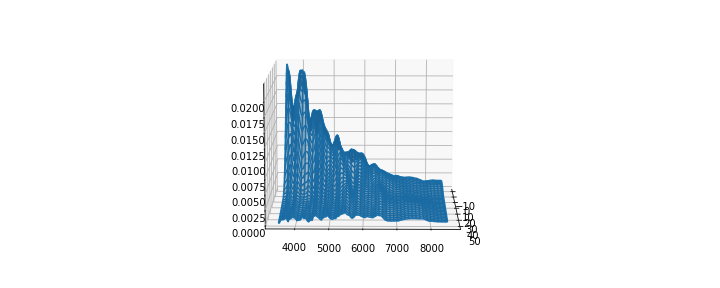

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2), value=0), Output()), _dom_classes=…

In [181]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp

%matplotlib notebook

fig = plt.figure(figsize=(10, 4))
ax = axes3d.Axes3D(fig)

def update_graph(i):
    
    ax.clear()
    
    Z = interp.griddata((xx,yy),pca.components_[i],(B1,B2),method='cubic')
    #Z = splinemean(B1, B2)
    #ax.scatter3D(xx,yy,pca.components_[i], c='r')
    ax.plot_wireframe(B1, B2, Z)
    ax.plot_surface(B1, B2, Z,alpha=0.4)
    #ax.set_zlim([0, 0.04])
    plt.show()
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)

widgets.interactive(update_graph,i = i)

# To export the templates

In [276]:
save_path = 'C:\\Users\\joao\\Documents\\GitHub\\SNFACTORY_SNTRAIN\\Templates'

In [2]:
f0 = BicubicInterpolator(X_GRID, Y_GRID, pca.components_[0].reshape(len(X_GRID), len(Y_GRID)))

NameError: name 'BicubicInterpolator' is not defined

In [ ]:
exp_x = []
exp_y = []
exp_z = []

for i in range(0,len(X_GRID)):
    
    for j in range(0,len(Y_GRID)):
        
        exp_x.append(X_GRID[i])
        exp_y.append(Y_GRID[j])
        exp_z.append(f0(X_GRID[i], Y_GRID[j])[0][0])

In [279]:

table = []
for l in range(0,len(exp_x)):
    table.append((exp_x[l],exp_y[l],exp_z[l]))

completeName = os.path.join(save_path, "M0.dat")

f = open(completeName, 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()


In [280]:
f1 = BicubicInterpolator(X_GRID, Y_GRID, pca.components_[1].reshape(len(X_GRID), len(Y_GRID)))

In [281]:
exp_x = []
exp_y = []
exp_z = []

for i in range(0,len(X_GRID)):
    
    for j in range(0,len(Y_GRID)):
        
        exp_x.append(X_GRID[i])
        exp_y.append(Y_GRID[j])
        exp_z.append(f1(X_GRID[i], Y_GRID[j])[0][0])

In [282]:
table = []
for l in range(0,len(exp_x)):
    table.append((exp_x[l],exp_y[l],exp_z[l]))


completeName = os.path.join(save_path, "M1.dat")

f = open(completeName, 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()


In [283]:
f2 = BicubicInterpolator(X_GRID, Y_GRID, pca.components_[2].reshape(len(X_GRID), len(Y_GRID)))

In [284]:
exp_x = []
exp_y = []
exp_z = []

for i in range(0,len(X_GRID)):
    
    for j in range(0,len(Y_GRID)):
        
        exp_x.append(X_GRID[i])
        exp_y.append(Y_GRID[j])
        exp_z.append(f2(X_GRID[i], Y_GRID[j])[0][0])

In [285]:
table = []
for l in range(0,len(exp_x)):
    table.append((exp_x[l],exp_y[l],exp_z[l]))


completeName = os.path.join(save_path, "M2.dat")

f = open(completeName, 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()

# Light Curve Fit

In [287]:
class ComboSource(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2']
    param_names_latex = ['x_0', 'x_1', 'x_2']
    
    
    def __init__(self, phase, wave, name='salt2', version='2010'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        SCALE_FACTOR = 1e-12
        #print(TOTAL_FACTOR)
        # ensure that fluxes are on the same scale
        #flux2 = flux1.max() / flux2.max() * flux2
        
        
        #reading the templates
        M0 = pd.read_csv("C:\\Users\\joao\\Documents\GitHub\\SNFACTORY_SNTRAIN\\Templates\\M0.dat", header = None, sep = "\s+", encoding='utf-8')
        M0.columns = ["time", "wave", "flux"]

        M1 = pd.read_csv("C:\\Users\\joao\\Documents\\GitHub\\SNFACTORY_SNTRAIN\\Templates\\M1.dat", header = None, sep = "\s+", encoding='utf-8')
        M1.columns = ["time", "wave", "flux"]

        M2 = pd.read_csv("C:\\Users\\joao\\Documents\\GitHub\\SNFACTORY_SNTRAIN\\Templates\\M2.dat", header = None, sep = "\s+", encoding='utf-8')
        M2.columns = ["time", "wave", "flux"]
        
        #c = pd.read_csv("/home/joao/Documents/pesquisa/LC_SALT_EXP/templates/salt2_colour_law_guy2010.dat", header = None, sep = "\s+")
        #print(c[0])
        #c.columns = ["wave", "ext"]
        
        
        M0 = M0.drop(M0[M0.time < -10].index)
        M0 = M0.drop(M0[M0.wave < 3500].index)
        M0 = M0.drop(M0[M0.wave > 7000].index)

        M1 = M1.drop(M1[M1.time < -10].index)
        M1 = M1.drop(M1[M1.wave < 3500].index)
        M1 = M1.drop(M1[M1.wave > 7000].index)
        
        M2 = M2.drop(M2[M2.time < -10].index)
        M2 = M2.drop(M2[M2.wave < 3500].index)
        M2 = M2.drop(M2[M2.wave > 7000].index)

        M0 = M0.reset_index(drop=True)
        M1 = M1.reset_index(drop=True)
        M2 = M2.reset_index(drop=True)
        

        gridx = np.linspace(-10, 50, 61)
        gridy = np.linspace(3500, 7000, 351)

        M0_reshape = np.array(M0["flux"]).reshape(61, 351)
        M1_reshape = np.array(M1["flux"]).reshape(61, 351)
        M2_reshape = np.array(M2["flux"]).reshape(61, 351)
    
        phase0, wave0, flux0 = gridx, gridy, M0_reshape
        phase1, wave1, flux1 = gridx, gridy, M1_reshape
        phase2, wave2, flux2 = gridx, gridy, M2_reshape
            
        flux0 *= SCALE_FACTOR
        flux1 *= SCALE_FACTOR
        flux2 *= SCALE_FACTOR
        
        self._model_flux0  = f0
        self._model_flux1  = f1    
        self._model_flux2  = f2
        #self._model_ext =  Spline1d(c['wave'], c['ext'],  k=1)  

        self._parameters = np.array([1, 0, 0])  # initial parameters
        

    def _flux(self, phase, wave):
        
        x0, x1, x2 = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave))

In [288]:
exp = ComboSource(X_GRID, Y_GRID, name='exp')

#exp = sncosmo.SALT2Source(modeldir=None, m0file='/home/joao/Documents/pesquisa/BackupSurfaces/PCA3comp/M0.dat', m1file='/home/joao/Documents/pesquisa/BackupSurfaces/PCA3comp/M1.dat', clfile='salt2_color_correction.dat', cdfile='salt2_color_dispersion.dat', errscalefile='salt2_lc_dispersion_scaling.dat', lcrv00file='salt2_lc_relative_variance_0.dat', lcrv11file='salt2_lc_relative_variance_1.dat', lcrv01file='salt2_lc_relative_covariance_01.dat', name=None, version=None)

In [289]:
fnames = glob.glob("C:\\Users\\joao\\Documents\\GitHub\\SNFACTORY_SNTRAIN\\JLA\\*.list")
print(len(fnames))

739


In [290]:
exc = []

In [291]:
table = []

In [292]:
for i in range(0, len(fnames)):    
    
    print(i)
    if i not in exc:
        
        data = sncosmo.read_lc(str(fnames[i]), format='salt2')
        
        if 0.01< data.meta['Z_HELIO'] < .08:
            
            if data["Filter"][0][:-3] == "MEGACAMPSF":

                r = math.sqrt(data.meta['X_FOCAL_PLANE']**2 + data.meta['Y_FOCAL_PLANE']**2)


                megacg = sncosmo.get_bandpass('megacampsf::g', r)
                megacr = sncosmo.get_bandpass('megacampsf::r', r)
                megaci = sncosmo.get_bandpass('megacampsf::i', r)
                megacz = sncosmo.get_bandpass('megacampsf::z', r)

                sncosmo.register(megacg, 'MEGACAMPSF::g', force = True)
                sncosmo.register(megacr, 'MEGACAMPSF::r', force = True)
                sncosmo.register(megaci, 'MEGACAMPSF::i', force = True)
                sncosmo.register(megacz, 'MEGACAMPSF::z', force = True)

            rname = data.meta['SN']

            model = sncosmo.Model(source=exp, effects=[sncosmo.F99Dust()], effect_names=['mw'], effect_frames=['obs'])

            model.set(mwebv=data.meta['MWEBV'], z = data.meta['Z_HELIO'])

            result, m = sncosmo.fit_lc(data, model, ['t0', 'x0', 'x1', 'x2'], modelcov=False, phase_range=(-10, 45.), wave_range=(4000., 7000.), verbose=False)

            #chiquad_list.append(result.chisq/result.ndof)

            if result.success == True:

                #print(result.chisq/result.ndof)

                if result.ndof > 2:
                    print("chi quad min/dof: ", result.chisq/result.ndof)
                    table.append((rname, result.parameters[0], result.parameters[1], result.errors['t0'], result.parameters[2], result.errors['x0'], result.parameters[3], result.errors['x1'], result.parameters[4], result.errors['x2'], data.meta['MWEBV'], result.covariance[1][2], result.covariance[1][3], result.covariance[2][3], result.chisq/result.ndof, "exp_emfa"))



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
chi quad min/dof:  43.70344406878922
257
258
259
260
261
262
263
264
265
266
267
2